In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Part I Exploratory data analysis

In [2]:
# Read the file
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## 1.1 Daily trends

In [3]:
# Aggregate by date
logins = logins.set_index('login_time')
logins['logins'] = 1
data = logins.resample('1D').sum()
data.head()

,logins
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [4]:
print('There were {} total logins from {} days.'\
      .format(data.logins.sum(), len(data)))

There were 93142 total logins from 103 days.


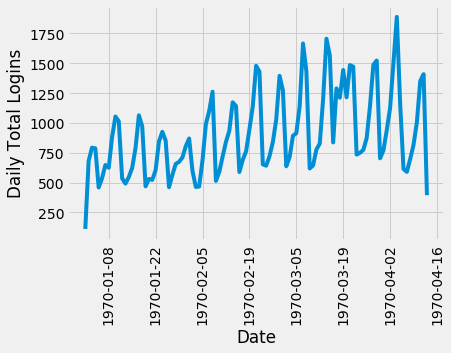

In [5]:
# Plot the daily trend
_ = plt.plot(data)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Date')
_ = plt.ylabel('Daily Total Logins')

Daily logins oscillated through the past few months. Overall, the logins seemd to slowly increase over time. My hypothesis here is that logins were different between weekdays and weekends.

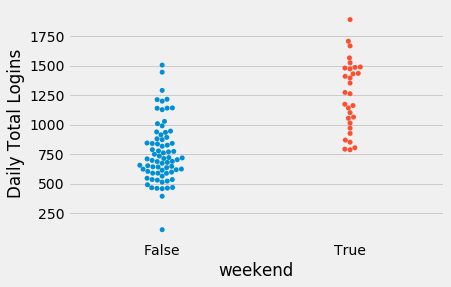

In [6]:
# Plot logins based on weekdays and weekends.
data['weekend'] = data.index.weekday >=5
_ = sns.swarmplot(x='weekend', y='logins', data=data)
_ = plt.ylabel('Daily Total Logins')

In [7]:
# Use t-test to see if the difference is significant
from scipy.stats import ttest_ind
weekend = data.loc[data.weekend==True, 'logins']
weekday = data.loc[data.weekend==False, 'logins']
t, p = ttest_ind(weekend, weekday)
print('t = {}\tp = {}'.format(t,p))

t = 8.46472731224942	p = 2.113648536307778e-13


Daily logins were significantly higher on weekends.
## 1.2 Hourly trends
Since weekends and weekdays are different, I will investigate these separately.

In [8]:
# Separate weekdays and weekends
weekday = logins.loc[logins.index.weekday<5]
weekend = logins.loc[logins.index.weekday>=5]
# Aggregate by 15-minute intervals
weekday = weekday.resample('15T').sum()
weekend = weekend.resample('15T').sum()
# Get the average of logins per time window
weekday['time'] = weekday.index.time
weekend['time'] = weekend.index.time
weekday = weekday.groupby('time')['logins'].mean()
weekend = weekend.groupby('time')['logins'].mean()

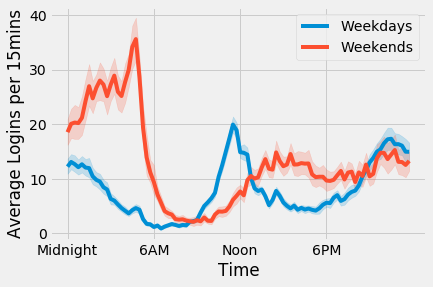

In [9]:
data = logins.resample('15T').sum()
data['time'] = data.index.time
data['time'] = data['time'].astype('category')
data['weekend'] = data.index.weekday>=5
data.head()
_ = sns.lineplot(x='time', y='logins', hue='weekend', data=data)
_ = plt.xticks(['00:00:00','06:00:00','12:00:00','18:00:00'],['Midnight','6AM','Noon','6PM'])
_ = plt.xlabel('Time')
_ = plt.ylabel('Average Logins per 15mins')
_ = plt.legend(['Weekdays', 'Weekends'])

# Part 3. Predictive modeling

In [10]:
# Load the data
import json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
data = pd.DataFrame(data)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
# Convert date columns to datetime
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])
print('Range of sign up dates is between {} and {}'
     .format(data['signup_date'].min(), data['signup_date'].max()))

Range of sign up dates is between 2014-01-01 00:00:00 and 2014-01-31 00:00:00


All sign up dates are in Jan., and we are looking at whether a user is still active in their 6th month. Therefore, all users whose last trip was in June can be considered active/retained.

In [12]:
# Calculate if a user is retained in the 6th month.
data['retained'] = data['last_trip_date']>=pd.to_datetime('2014-06-01')
# Drop dates columns that won't be used again.
data.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)
# Convert boolean columns into int.
data['ultimate_black_user'] = data['ultimate_black_user'].astype(int)
data['retained'] = data['retained'].astype(int)
# See how many users were retained.
print('Out of {} users, {} were still active in their 6th month.'
     .format(len(data), data['retained'].sum()))

Out of 50000 users, 18804 were still active in their 6th month.


## 3.1 EDA

In [13]:
# Quickly explore which features have strongest correlation with retention.
data.corr()['retained']

avg_dist                 -0.092780
avg_rating_by_driver     -0.026791
avg_rating_of_driver     -0.011653
avg_surge                -0.003333
surge_pct                 0.011797
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
weekday_pct               0.009693
retained                  1.000000
Name: retained, dtype: float64

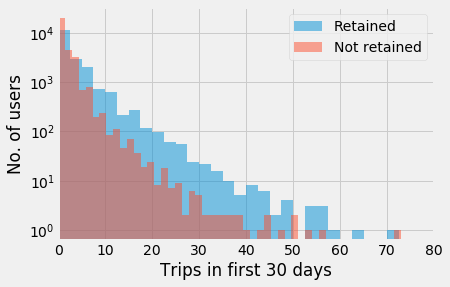

In [14]:
# Visualize some of them.
retained = data.loc[data.retained==1]
not_retained = data.loc[data.retained==0]
_ = plt.hist(retained['trips_in_first_30_days'], bins=50, alpha=0.5, label='Retained')
_ = plt.hist(not_retained['trips_in_first_30_days'], bins=50, alpha=0.5, label='Not retained')
_ = plt.xlabel('Trips in first 30 days')
_ = plt.ylabel('No. of users')
_ = plt.xlim([0,80])
_ = plt.yscale('log')
_ = plt.legend()

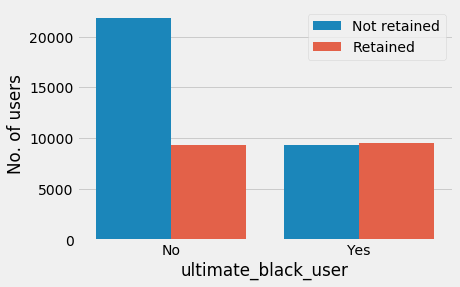

In [15]:
_ = sns.countplot(x='ultimate_black_user', hue='retained', data=data)
_ = plt.legend(['Not retained', 'Retained'])
_ = plt.ylabel('No. of users')
_ = plt.xticks([0,1],['No','Yes'])

In [16]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['ultimate_black_user'], data['retained'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 2100.4182024974366	p = 0.0


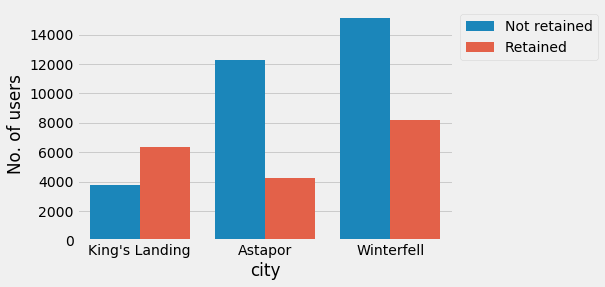

In [17]:
# Visualize the two categorical features, city and phone
_ = sns.countplot(x='city', hue='retained', data=data)
_ = plt.legend(['Not retained', 'Retained'], bbox_to_anchor=(1,1))
_ = plt.ylabel('No. of users')

In [18]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['city'], data['retained'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 3821.5510225559638	p = 0.0


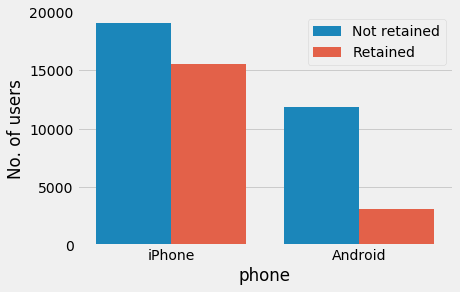

In [19]:
# Phone
_ = sns.countplot(x='phone', hue='retained', data=data)
_ = plt.legend(['Not retained', 'Retained'])
_ = plt.ylabel('No. of users')

In [20]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['phone'], data['retained'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 2558.3942122674252	p = 0.0


## 3.2 Preprocessing

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: float64(6), int64(3), object(2)
memory usage: 4.2+ MB


In [22]:
# Impute ratings with means.
data.fillna({'avg_rating_by_driver':data['avg_rating_by_driver'].mean()}, inplace=True)
data.fillna({'avg_rating_of_driver':data['avg_rating_of_driver'].mean()}, inplace=True)
# Cannot impute phone types, drop those rows instead.
data.dropna(inplace=True)

In [23]:
# Separate the target data
target = data['retained']
data.drop('retained', axis=1, inplace=True)
# Transform categorical data into dummy variables
data['iphone'] = pd.get_dummies(data['phone'], drop_first=True)
data.drop('phone', axis=1, inplace=True)
data = pd.concat([data, pd.get_dummies(data['city'], drop_first=True)], axis=1)
data.drop('city', axis=1, inplace=True)
# Sclae the features
from sklearn.preprocessing import scale
scaled_data = pd.DataFrame(scale(data))
scaled_data.columns = data.columns
scaled_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,iphone,King's Landing,Winterfell
0,-0.373113,0.497826,0.174300,0.112318,0.326417,0.454159,1.290412,-0.395941,0.659081,1.981887,-0.934523
1,0.436461,0.497826,0.705065,-0.336789,-0.444014,-0.600342,-0.774946,-0.293477,-1.517264,-0.504570,-0.934523
2,-0.884608,0.497826,-0.533387,-0.336789,-0.444014,0.190534,-0.774946,1.054746,0.659081,-0.504570,-0.934523
3,-0.604167,0.273719,-0.002622,0.291961,0.556545,1.772286,1.290412,0.515457,0.659081,1.981887,-0.934523
4,-0.468357,0.273719,-0.356465,0.516515,0.146316,3.090412,-0.774946,0.580172,-1.517264,-0.504570,1.070064


In [24]:
# Create training and testing datasets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data, target, random_state=42)

The purpose of this study is to guide business and marketing team about the important factors that might determine whether a user is retained or not. Therefore, the interpreterbility of the model is more important than its performance. Because of that, I decided to choose logistic regression as the algorithm and accuracy as the metric.
## 3.3 Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Tune C and penalty
clf = LogisticRegression(random_state=42)
params = {
    'C': [1e-5, 1e-4, 0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2']
}
model = GridSearchCV(clf, params, scoring='accuracy')
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best accuracy was', model.best_score_)

Best parameters were {'C': 0.0001, 'penalty': 'l2'}
Best accuracy was 0.719646265086


In [26]:
# Evaluate model using test sets
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
logreg = LogisticRegression(C=0.0001, penalty='l2', random_state=42)
logreg.fit(Xtrain, ytrain)
ypred = logreg.predict(Xtest)
print('Accuracy of test set was {}\n'.format(accuracy_score(ytest, ypred)))
print(classification_report(ytest, ypred))
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
     .format(tn,fp,fn,tp))

Accuracy of test set was 0.7197000241915974

             precision    recall  f1-score   support

          0       0.74      0.86      0.79      7750
          1       0.67      0.49      0.57      4651

avg / total       0.71      0.72      0.71     12401

True Negative = 6637	False Positive = 1113
False Negative = 2363	True Positive=2288


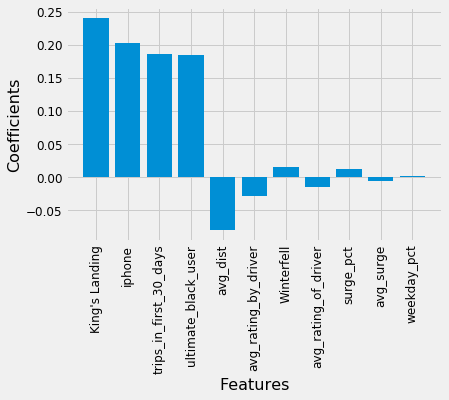

In [27]:
# Extract coefficients.
coefs = pd.Series(logreg.coef_.reshape(-1), index=scaled_data.columns)
# Sort by absolute values of coefficients.
coefs = coefs[coefs.abs().sort_values(ascending=False).index]
# Plot
_ = plt.bar(range(len(coefs)), coefs)
_ = plt.xticks(range(len(coefs)), coefs.index, rotation=90)
_ = plt.xlabel('Features', fontsize=16)
_ = plt.ylabel("Coefficients", fontsize=16)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

The 4 most important features are whether the user is in King's Landing, whether the user is an iphone user, how many trips in the first 30 days, and whether the user is a Ultimate Black user.